In [18]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from scipy import stats
from scipy.optimize import minimize

import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as wb

from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, Tuple

"""
Own packages
"""

from codelib.statistics import calculate_cornish_fisher_percentile
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std
from codelib.portfolio_optimization.risk_metrics import calculate_normal_cond_value_at_risk, calculate_normal_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_normal_port_cond_value_at_risk, calculate_normal_port_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_conditional_value_at_risk, calculate_value_at_risk
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_cvar, calculate_risk_contributions_cvar

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercises - Week 4

In this week we will look at a few exercises involving  risk mesures and allocating diversification benefits. 

## Problem 1: VaR and CVaR using historical simulation 

A common approach to estimate $\text{VaR}$ and $\text{CVaR}$ is simply to use or simulate from the empirical distribution function. Some are strong proponents of this method since it does not require distributional assumptions about returns, but one need to be carefull since one will often make an independence assumption and sometimes a particular model assumption may give more robust results. Blindly using the empirical distribution may limit the attention to tail events. 



__Question 1__

Obtain the value weighted monthly return data for the five Fama-French industry portfolios ("5_Industry_Portfolios") using `pandas-datareader` since 1990-01-01  and transform the value weighted monthly return data into log returns.


__Question 2__

Resample 10,000 vectors of returns from the monthly log returns calculated above. Use e.g. `np.random.randint`. Plot the histogram of an equally weighted portfolio (linear returns). Calculate the 5\% $\text{VaR}$ and $\text{CVaR}$ of an equally weighted portfolio (linear returns) using the resampled / simulated data. 

__Question 3__

Resample 10,000 x 12 vectors of returns from the monthly log returns calculate above such to you are able to calculate the yearly portfolio return. Use e.g. `np.random.randint`. Plot the histogram of an equally weighted portfolio (yearly, linear returns). Calculate the 5\% $\text{VaR}$ and $\text{CVaR}$ of an equally weighted portfolio (linear returns) using the resampled / simulated data.

__Question 4__

Based on the portfolio returns found in question 3, use the Cornish-Fisher approximation to calculate the 5\% $\text{VaR}$ of the yearly portfolio return. Note the function `calculate_cornish_fisher_percentile` in `codelib.statistics`.

### Solution 

__Question 1__

In [19]:
# import pandas_datareader as pdr
# from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

reader = FamaFrenchReader("5_Industry_Portfolios", start=datetime.datetime(1990, 1, 1))
industry_port_daily = reader.read()

# print description
industry_port_daily['DESCR']

# get value weighted
ind_eq_weighted = industry_port_daily[0]

# get log returns
eq_log_returns = np.log1p(ind_eq_weighted / 100.0)
eq_log_returns.head()

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
1990-01,-0.057947,-0.044056,-0.058053,-0.056253,-0.053506
1990-02,0.018036,0.029170,0.031983,0.015578,0.009158
1990-03,0.034981,0.037488,0.038259,0.043730,-0.001802
1990-04,-0.024600,-0.026857,-0.021019,-0.008637,-0.035420
1990-05,0.042485,0.046884,0.074458,0.078441,0.022055


In [20]:
eq_log_returns.shape

(402, 5)

__Question 2__

In [21]:
"""
Define resampling function 
"""

def resample(data: np.ndarray, num_sim: int, num_per: int = 1):
    
    """
    Resample input data

    Parameters
    ----------
    data: 
        Data matrix, time x assets
    num_sim: 
        Number of simulations. 
    num_per: 
        Number of periods. 

    Returns
    -------
    np.ndarray
        Ressampled data, (num_sim, num_per, number of assets)

    """
    # number of assets
    n = len(data)
    # get index for selecting data
    idx = np.random.randint(n, size=(num_sim, num_per))
    
    return data[idx, :]

In [22]:
"""
Simulate one month log-returns and transform to port. returns
"""
port_w = np.repeat(1.0/5.0, 5)
num_sim = 10000
num_per = 1

sim_log_returns = resample(eq_log_returns.values, num_sim=num_sim, num_per=num_per)
sim_lin_returns = np.exp(sim_log_returns) - 1.0
sim_port_returns = sim_lin_returns @ port_w

# note that for the one period case, you will obtain the same results by using 
# sim_port_returns = resample(ind_eq_weighted / 100.0, num_sim=num_sim, num_per=num_per)

"""
Calculate VaR and CVaR
"""

value_at_risk = np.percentile(sim_port_returns, 5)
cond_value_at_risk = np.mean(sim_port_returns[sim_port_returns <= value_at_risk])

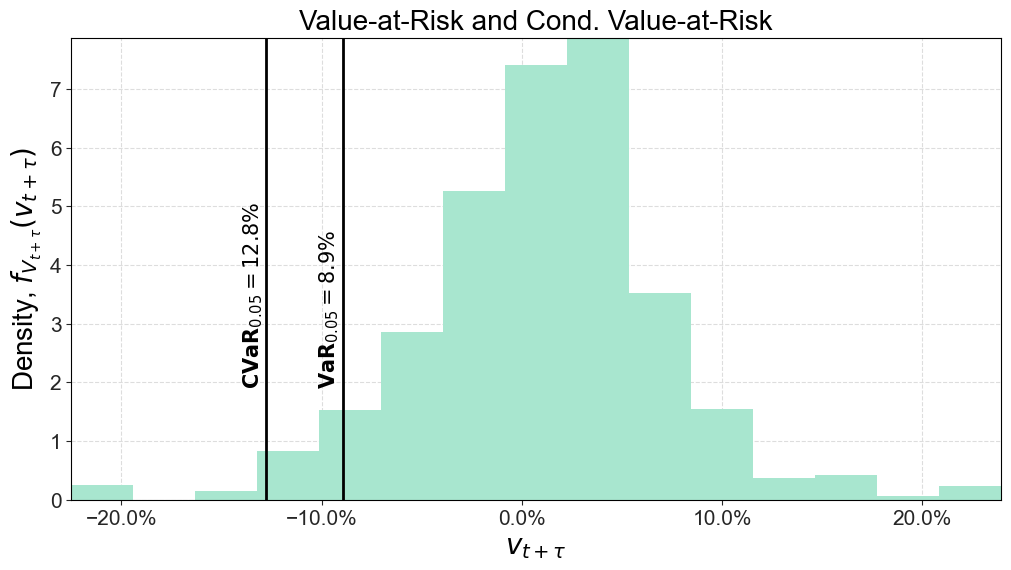

In [23]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_port_returns, density=True, bins=15);

ax.axvline(value_at_risk, ymin=0, ymax=8, color="black")
ax.axvline(cond_value_at_risk, ymin=0, ymax=8, color="black")
ax.set_title("Value-at-Risk and Cond. Value-at-Risk", size=20)
ax.set_xlabel('$v_{t + \\tau}$', size=20)
ax.set_ylabel('Density, $f_{V_{t + \\tau}}(v_{t + \\tau})$', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.1f}\%$".format(-value_at_risk*100)
ax.text(-0.102, 2.0, text_to_add, rotation=90);

text_to_add_2 =  "$\mathbf{CVaR}_{0.05}" + " = {:,.1f}\%$".format(-cond_value_at_risk*100)
ax.text(-0.14, 2.0, text_to_add_2,rotation=90);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

__Question 3__

In [24]:
"""
Simulate 12 month log-returns and transform to port. returns
"""
port_w = np.repeat(1.0/5.0, 5)
num_sim = 10000
num_per = 12

sim_log_returns = resample(eq_log_returns.values, num_sim=num_sim, num_per=num_per)
sim_lin_returns = np.exp(sim_log_returns.sum(axis=1)) - 1.0
sim_port_returns = sim_lin_returns @ port_w

"""
Calculate VaR and CVaR
"""

value_at_risk = np.percentile(sim_port_returns, 5)
cond_value_at_risk = np.mean(sim_port_returns[sim_port_returns <= value_at_risk])

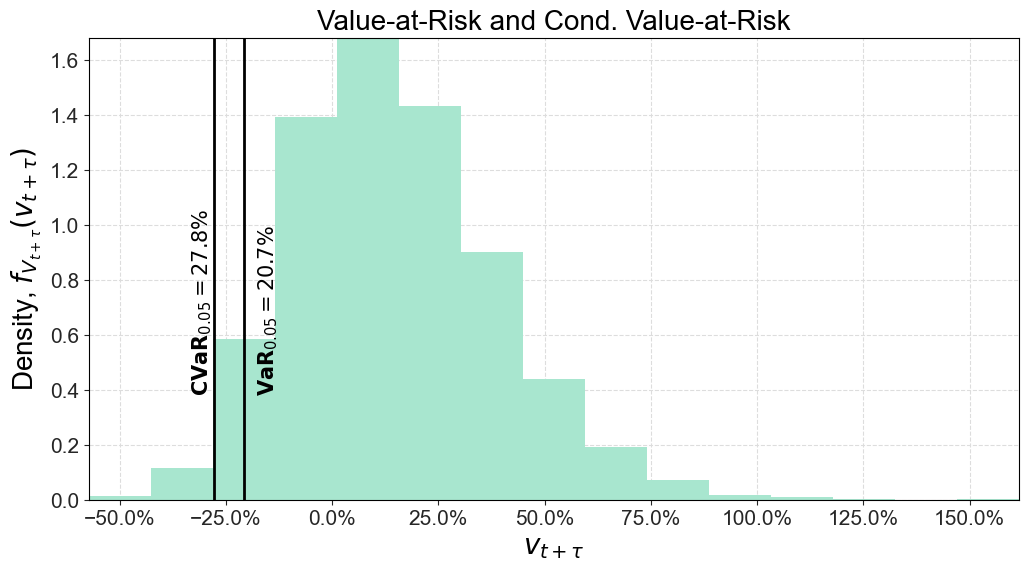

In [25]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_port_returns, density=True, bins=15);

ax.axvline(value_at_risk, ymin=0, ymax=8, color="black")
ax.axvline(cond_value_at_risk, ymin=0, ymax=8, color="black")
ax.set_title("Value-at-Risk and Cond. Value-at-Risk", size=20)
ax.set_xlabel('$v_{t + \\tau}$', size=20)
ax.set_ylabel('Density, $f_{V_{t + \\tau}}(v_{t + \\tau})$', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.1f}\%$".format(-value_at_risk*100)
ax.text(value_at_risk + 0.03, 0.4, text_to_add, rotation=90);

text_to_add_2 =  "$\mathbf{CVaR}_{0.05}" + " = {:,.1f}\%$".format(-cond_value_at_risk*100)
ax.text(cond_value_at_risk - 0.055, 0.4, text_to_add_2,rotation=90);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

__Question 4__

In [26]:
est_mean = np.mean(sim_port_returns)
est_sigma = np.std(sim_port_returns)
est_skew = stats.skew(sim_port_returns)
est_kurt = stats.kurtosis(sim_port_returns)

cf_var = calculate_cornish_fisher_percentile(0.05, est_mean, est_sigma, est_skew, est_kurt)
cf_var

-0.20268385875862963

## Problem 2: Maximum drawdown

[Drawdown](https://en.wikipedia.org/wiki/Drawdown_(economics)) is a measure of the decline from a historical peak. The drawdown at time $T$ from the starting time $0$ can be defined as (we are using linear returns, but it could also be the loss itself)

$$
DD(T) = \min \left[ \frac{P_T - \max_{t \in (0, T)} P_t}{\max_{t \in (0, T)} P_t}, 0\right]
$$

The maximum drawdown (the most negative return) is 

$$
MDD(T) = \min_{t \in (0, T)} \left[ \frac{P_T - \max_{t \in (0, T)} P_t}{\max_{t \in (0, T)} P_t}, 0\right]
$$

__Question 1__

Implement two functions that calculate respectively the drawdown and maximum drawdown. Let the drawdown function return the drawdown at each point in time. 

__Question 2__

Plot the drawdown of SP500 since 1990-01-01 (hint: use `pandas-datareader`, ticker: '^GSPC', data_source: 'yahoo'). What is the maximum draw down?

### Solution 

__Question 1__

In [27]:
def drawdown(index: np.ndarray):
    
    """
    Calculates the running draw down 
    
    Parameters
    ----------
    index: 
        Values of e.g. at equity index
        
    Returns
    -------
    Tuple(np.ndarray, np.ndarray)
        Drawdown, index of running maximum
    
    """
    
    indexmax = index.cummax()
    drawdowns = (index - indexmax) / indexmax
    
    return drawdowns, indexmax
    
def maxdrawdown(index: np.ndarray):

    """
    Calculates maximum draw down 
    
    Parameters
    ----------
    index: 
        Values of e.g. at equity index
        
    Returns
    -------
    float
        Maximum drawdown
    
    """
    
    return drawdown(index)[0].min()
        

__Question 2__

[*********************100%%**********************]  1 of 1 completed


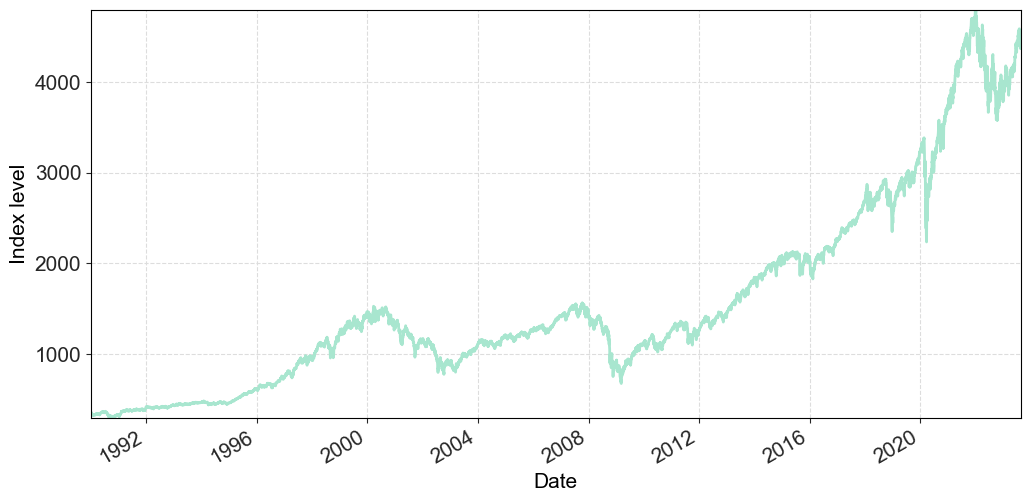

In [69]:
sp500_adjclose = wb.get_data_yahoo('^GSPC', start=datetime.date(1990, 1, 1))['Adj Close']
sp500_adjclose.plot(figsize=(12,6), ylabel="Index level");

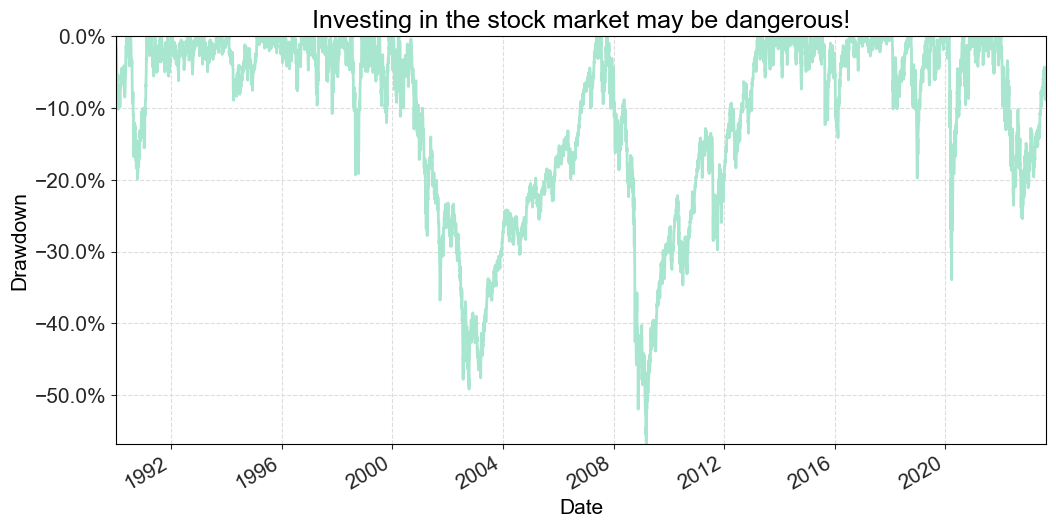

In [70]:
"""
Plotting drawdown plot
"""

ax = drawdown(sp500_adjclose)[0].plot(figsize=(12, 6));

ax.set_title('Investing in the stock market may be dangerous!')
ax.set_ylabel('Drawdown')

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.yaxis.set_major_formatter(xticks)

In [30]:
maxdrawdown(sp500_adjclose)

-0.5677538774277282

## Problem 3: Portfolio diversification

Assume that an investor has a quadratic utility function 

$$
U(\mathbf{w}) = \mathbf{w}^\top \boldsymbol{\mu} - \frac{\lambda}{2} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

where $\mathbf{w}$ is the portfolio weights, $\boldsymbol{\mu}$ is a vector of expected returns, and $\boldsymbol{\Sigma}$ denotes the covariance matrix. 

The investor seeks to maximize the utility given the constraint that the portfolio weights sum to one

$$
\mathbf{1}^\top \mathbf{w} = 1
$$

The solution to this optimization problem is given by (see e.g. [Rebonato and Denev, "Portfolio Management under stress"](https://www.amazon.com/Portfolio-Management-under-Stress-Bayesian-Net/dp/1107048117))

$$
\mathbf{w}^* = \frac{1}{\lambda} \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} - \frac{1}{\lambda} \boldsymbol{\Sigma}^{-1} \mathbf{A}^\top \mathbf{C}^{-1} \left(\mathbf{A}\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}  - \lambda \mathbf{b} \right)
$$

with $\mathbf{A} = \mathbf{1}^\top$, $\mathbf{b} = 1$, and $\mathbf{C} = \mathbf{A} \boldsymbol{\Sigma}^{-1}\mathbf{A}^\top$. Note that this solution is valid for more general constraints of the form $\mathbf{A}^\top \mathbf{w} = \mathbf{b}$. 


We assume that 

$$
\boldsymbol{\mu}  = \begin{bmatrix} 0.02 \\ 0.04 \\ 0.08 \end{bmatrix}, \; \mathbf{v} = \begin{bmatrix} 0.075 \\ 0.15 \\ 0.3 \end{bmatrix}, \; \textbf{Corr} = \begin{bmatrix} 1.0 & 0.2 & 0.1 \\
                     0.2 & 1.0 & 0.4 \\
                     0.1 & 0.4 & 1.0 \end{bmatrix}
$$


__Question 1__

Calculate the covariance matrix. One possibility is to use the trick 

$$
\boldsymbol{\Sigma} = \mathbf{v} \mathbf{v}^\top \odot \textbf{Corr}
$$

where $\mathbf{v} \mathbf{v}^\top$ is the outer product and $\odot$ denotes the element-by-element product (Hadamard product).  


__Question 2__

Define a function that calculates the optimal weights. The function should take three inputs: expected value, covariance matrix and risk aversion. 

Calculate the optimal weights when $\lambda = 5$. 

__Question 3__

Define a function that calculates the relative risk contributions. The function should take two inputs: portfolio weights and the covariance matrix. Calculate the relative risk contribution using the optimal weights from question 2. 

Note that we in the lectures defined the risk contribution as

$$
\text{RC}_i(\mathbf{w}) = w_i \frac{\partial \sigma_P(\mathbf{w}) }{\partial w_i} = w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

Dividing with the portfolio standard deviation gives us the relative risk contribution 

$$
\text{RRC}_i(\mathbf{w}) =  w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} \frac{1}{\sqrt{ \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$



__Question 4__

Calculate the optimal weights and the corresponding relative risk contribution for 100 values of the risk aversion parameter in the interval $\lambda \in [1.2, 20.0]$?

Note that one could make a for loop that for each value of the risk aversion parameter in `risk_aversions` created using `np.linspace(1.2, 20.0, 100)` calculates the optimal weights and relative risk contribution and store them in `optimal_weights = np.zeros((3, len(risk_aversions)))` and `rel_risk_contribs = np.zeros((3, len(risk_aversions)))`. 


__Question 5__

Use a [stackplot](https://matplotlib.org/stable/gallery/lines_bars_and_markers/stackplot_demo.html) to plot the optimal weights and the relative risk contributions for each value of $\lambda$ (two different plots). The code should look something like when plotting the optimal weights

```python
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(risk_aversions, optimal_weights, labels=['Asset 1', 'Asset 2', 'Asset 3']); 
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('$w$')
ax.set_title('Optimal weights')
ax.legend(loc='upper left')
```

### Solution 

__Question 1__

In [31]:
mu = np.array([0.02, 0.04, 0.08])
vols = np.array([0.075, 0.15, 0.3])
corr_mat = np.array([[1.0, 0.2, 0.1],
                     [0.2, 1.0, 0.4],
                     [0.1, 0.4, 1.0]])

cov_mat = np.outer(vols, vols) * corr_mat
cov_mat

array([[0.005625, 0.00225 , 0.00225 ],
       [0.00225 , 0.0225  , 0.018   ],
       [0.00225 , 0.018   , 0.09    ]])

__Question 2__

In [32]:
"""
Define quadratic utility function 
"""

def quadratic_utility(weights: np.ndarray, mu: np.ndarray, cov_matrix: np.ndarray, risk_aversion: float) -> float:
    
    """
    Function that returns the quadratic utility of a given allocation
    
    Parameters
    ----------
    weights: 
        Portfolio weights
    mu: 
        Expected returns
    cov_matrix: 
        Covariance matrix
    risk_aversion: 
        Risk aversion parameter
    
    Returns
    -------
    float
        Utility
    """
    return weights @ mu - 0.5 * risk_aversion * weights @ cov_matrix @ weights

"""
Define optimal weights function
"""

def calculate_optimal_weights(mu: np.ndarray, cov_matrix: np.ndarray, risk_aversion: float) -> np.ndarray: 
    
    """
    Function that calculates optimal port. weights
    
    Parameters
    ----------
    mu: 
        Expected returns
    cov_matrix: 
        Covariance matrix
    risk_aversion: 
        Risk aversion parameter
    
    Returns
    -------
    float
        Optimal portfolio weights
    """
    sigma_inv = np.linalg.inv(cov_matrix)
    A = np.ones_like(mu)
    C = A @ sigma_inv @ A
    C_inv = 1.0 / C
    b = 1.0
    
    first_part = 1.0 / risk_aversion * sigma_inv @ mu 
    second_part = 1.0 / risk_aversion * sigma_inv @ A * C_inv * (A @ sigma_inv @ mu - risk_aversion * b)
    
    opt_weights = first_part - second_part
    
    return opt_weights

def calculate_optimal_weights_alternative(mu: np.ndarray, cov_matrix: np.ndarray, risk_aversion: float) -> np.ndarray: 
    
    """
    Function that calculates optimal port. weights
    
    Parameters
    ----------
    mu: 
        Expected returns
    cov_matrix: 
        Covariance matrix
    risk_aversion: 
        Risk aversion parameter
    
    Returns
    -------
    float
        Optimal portfolio weights
    """
    
    ones = np.ones_like(mu)
    sigma_inv = np.linalg.inv(cov_matrix)
    
    a = ones @  sigma_inv @ mu
    b = ones @  sigma_inv @ ones
    
    r_inv = 1.0 / risk_aversion
    
    gamma = a / b - risk_aversion / b 
    
    opt_weights = r_inv * sigma_inv @mu - r_inv * gamma * sigma_inv @ ones
    
    return opt_weights


In [33]:
risk_aversion = 5
print("optimal weights: ")
w_opt = calculate_optimal_weights(mu, cov_mat, risk_aversion)
w_opt

optimal weights: 


array([0.66414857, 0.2115203 , 0.12433113])

__Question 3__

In [34]:
def calculate_marginal_risks_std(weights: np.ndarray, cov_matrix: np.ndarray) -> np.ndarray:
    
    """
    Function that calculates marginal risk
    Parameters
    ----------
    weights: 
        Portfolio weights
    cov_matrix: 
        Covariance matrix
    
    Returns
    -------
    np.ndarray
        Marginal risks
    """
    
    total_risk = np.sqrt(weights @ cov_matrix @ weights)
    inner_derivative = cov_matrix @ weights
    
    return inner_derivative / total_risk

def calculate_risk_contributions_std(weights: np.ndarray, cov_matrix: np.ndarray, scale: bool = False) -> np.ndarray:
    
    """
    Function that calculates risk contributions
    
    Parameters
    ----------
    weights: 
        Portfolio weights
    cov_matrix: 
        Covariance matrix
    
    Returns
    -------
    np.ndarray
        Marginal risks
    """
    
    mr = calculate_marginal_risks_std(weights, cov_matrix)
    
    if scale: 
        mr /= np.sqrt(weights @ cov_matrix @ weights)
    
    return weights * mr

In [35]:
print("relative risk contribution: ")
rel_risk_contrib = calculate_risk_contributions_std(w_opt, cov_mat, scale=True)
rel_risk_contrib

relative risk contribution: 


array([0.43678156, 0.26299292, 0.30022551])

__Question 4__

In [36]:
risk_aversions = np.linspace(1.2, 20.0, 100)
optimal_weights = np.zeros((3, len(risk_aversions)))
rel_risk_contribs = np.zeros((3, len(risk_aversions)))

for _, risk_aversion in enumerate(risk_aversions):
    optimal_weights[:, _] = calculate_optimal_weights(mu, cov_mat, risk_aversion)
    rel_risk_contribs[:, _] = calculate_risk_contributions_std(optimal_weights[:, _], cov_mat, scale=True)

__Question 5__

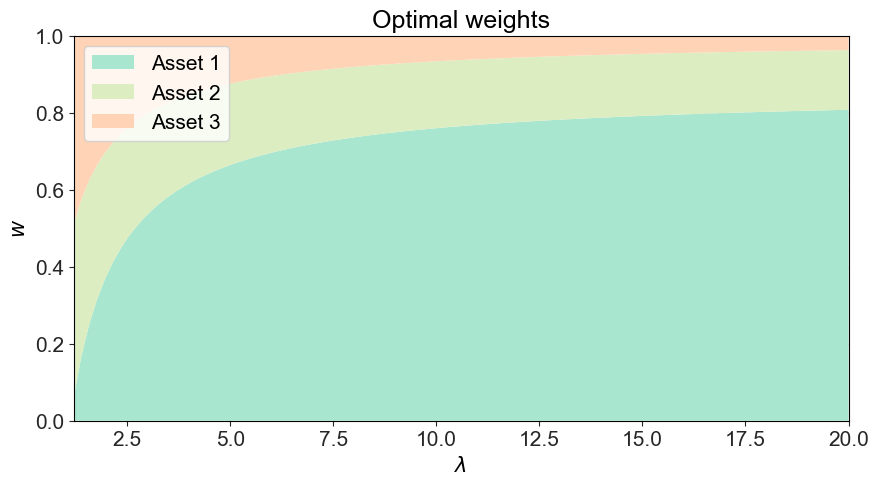

In [37]:
"""
Optimal weights
"""
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(risk_aversions, optimal_weights, labels=['Asset 1', 'Asset 2', 'Asset 3']); 
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('$w$')
ax.set_title('Optimal weights')
ax.legend(loc='upper left');

__Question 6__

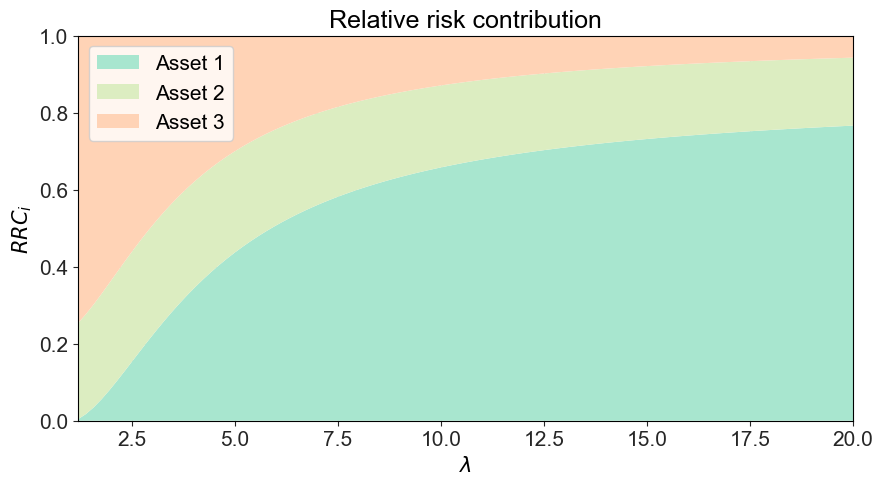

In [38]:
"""
Optimal weights
"""
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(risk_aversions, rel_risk_contribs, labels=['Asset 1', 'Asset 2', 'Asset 3']); 
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('$RRC_i$')
ax.set_title('Relative risk contribution')
ax.legend(loc='upper left');
 

The analysis shows us that looking only at portfolio weights may be misleading when trying to understand the risk drivers of the portfolio. 

### Check formula

In [39]:
objective = lambda w: -quadratic_utility(w, mu, cov_mat, 5)

sum_to_on_constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}

res = minimize(objective, [0.0/3.0, 1.0/3.0, 2.0/3.0], constraints=sum_to_on_constraint)
res.x

array([0.66416497, 0.21152601, 0.12430901])

## Problem 4: Allocating diversification benefits for VaR and CVaR

In this problem, we will learn how to perform risk decompostion if we for simplicity assume that the linear returns follow a normal distribution. 

As in problem 3, assume that 

$$
\boldsymbol{\mu}  = \begin{bmatrix} 0.02 \\ 0.04 \\ 0.08 \end{bmatrix}, \; \mathbf{v} = \begin{bmatrix} 0.075 \\ 0.15 \\ 0.3 \end{bmatrix}, \; \textbf{Corr} = \begin{bmatrix} 1.0 & 0.2 & 0.1 \\
                     0.2 & 1.0 & 0.4 \\
                     0.1 & 0.4 & 1.0 \end{bmatrix}
$$

and add the assumption that the returns follow a multivariate normal distribution

$$
\mathbf{R} \sim \text{MVN}(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

where $\boldsymbol{\Sigma}$ is the covariance matrix. We know that we can write the portfolio mean as ($\mathbf{w}$ is the portfolio weights)

$$
\mu_P(\mathbf{w}) = \mathbf{w}^\top \boldsymbol{\mu}
$$

and the standard deviation as 

$$
\sigma_P(\mathbf{w}) = \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}
$$

such that the portfolio return follows a normal distribution

$$
R_P = \mathbf{w}^\top \mathbf{R} \sim N(\mu_P(\mathbf{w}), \sigma_P^2(\mathbf{w}))
$$


Furthermore, consider an equally weighted portfolio. 

__Question 1__


Given our understanding of the normal distribution, we can calculate the VaR as 

$$
\text{VaR}_{\alpha} (\mathbf{w}) = - \mu_P(\mathbf{w}) + \sigma_P(\mathbf{w}) \Phi^{-1}(1 - \alpha)
$$

where $\phi()$ and $\Phi^{-1}()$ denote the standard normal pdf and quantile function respectively. 

The CVaR is given by

$$
\text{CVaR}_{\alpha} = -\mu_P + \sigma_P \frac{\phi\left(\Phi^{-1}(\alpha) \right)}{\alpha}
$$ 

Calculate VaR(5%) and CVaR(5%) of an equally weighted portfolio using the normal assumption. 


__Question 2__

We can decompose the VaR using 

$$
\text{VaR}_{\alpha}(\mathbf{w}) = \sum_{i=1}^N w_i \frac{\partial \text{VaR}_{\alpha}(\mathbf{w})}{\partial w_i}
$$


Find the marginal risk (use e.g. the chain-rule)

$$
\frac{\partial \text{VaR}_{\alpha}(\mathbf{w})}{\partial w_i},
$$

implement a function calculating the marginal risk and risk contribution, and calculate the values for an equally weighted portfolio. 

Is the VaR equal to the sum of the risk contributions?

__Question 3__

We can decompose the CVaR using 

$$
\text{CVaR}_{\alpha}(\mathbf{w}) = \sum_{i=1}^N w_i \frac{\partial \text{CVaR}_{\alpha}(\mathbf{w})}{\partial w_i}
$$

Find the marginal risk

$$
\frac{\partial \text{CVaR}_{\alpha}(\mathbf{w})}{\partial w_i},
$$

implement a function calculating the marginal risk and risk contribution, and calculate the values for an equally weighted portfolio. 

Is the CVaR equal to the sum of the risk contributions?

### Solution

__Question 1__

We simply define functions that implement the above definitions. See `codelib.portfolio_optimization.risk_metrices` for the definition of the functions. 

In [40]:
mu = np.array([0.02, 0.04, 0.08])
vols = np.array([0.075, 0.15, 0.3])
corr_mat = np.array([[1.0, 0.2, 0.1],
                     [0.2, 1.0, 0.4],
                     [0.1, 0.4, 1.0]])

cov_mat = np.outer(vols, vols) * corr_mat
cov_mat

weights = np.repeat(1.0 / 3.0, 3)

In [41]:
-calculate_normal_port_value_at_risk(weights, mu, cov_mat)

0.17477852995199877

In [42]:
-calculate_normal_port_cond_value_at_risk(weights, mu, cov_mat)

0.23103454378869823

__Question 2__

First, we need to find 

$$
\frac{\partial \text{VaR}_{\alpha}(\mathbf{w})}{\partial w_i} 
$$

We can simply use the chain-rule and that (what we have seen at the lectures)

$$
\nabla \sigma_P(\mathbf{w}) = \frac{d \sigma_P(\mathbf{w}) }{d \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}\frac{\partial \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}{\partial \mathbf{w}} = \frac{1}{2\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} 2 \boldsymbol{\Sigma} \mathbf{w} = \frac{\boldsymbol{\Sigma} \mathbf{w} }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$


We find 

$$
\nabla \text{VaR}_{\alpha} = -\boldsymbol{\mu} +  \Phi^{-1}(1 - \alpha) \nabla \sigma_P(\mathbf{w}) = -\boldsymbol{\mu} +  \Phi^{-1}(1 - \alpha)  \frac{\boldsymbol{\Sigma} \mathbf{w} }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

Thus, 

$$
\frac{\partial \text{VaR}_{\alpha}(\mathbf{w})}{\partial w_i} = -\mu_i +  \Phi^{-1}(1 - \alpha)  \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

In [43]:
def calculate_marginal_risks_normal_var(weights: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    """
    Function that calculates marginal risk using Value-at-Risk as risk measure.
    It is assumed that returns follow a normal distribution.

    Parameters
    ----------
    weights:
        Portfolio weights
    mu:
        Vector of expected returns
    cov_mat:
        Covariance matrix
    alpha:
        Confidence level

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr_std = calculate_marginal_risks_std(weights, cov_mat)
    
    mr_var = -mu + stats.norm.ppf(1.0 - alpha) * mr_std
    
    return mr_var

In [44]:
def calculate_risk_contributions_normal_var(weights: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    """
    Function that calculates marginal risk using Value-at-Risk as risk measure.
    It is assumed that returns follow a normal distribution.

    Parameters
    ----------
    weights:
        Portfolio weights
    mu:
        Vector of expected returns
    cov_mat:
        Covariance matrix
    alpha:
        Confidence level

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr = calculate_marginal_risks_normal_var(weights, mu, cov_mat, alpha=alpha)
    
    return weights * mr

In [45]:
mr_var = calculate_marginal_risks_normal_var(weights, mu, cov_mat, alpha=0.05)
mr_var

array([0.02123462, 0.13410174, 0.36899923])

In [46]:
mrc_var = calculate_risk_contributions_normal_var(weights, mu, cov_mat, alpha=0.05)
mrc_var

array([0.00707821, 0.04470058, 0.12299974])

In [47]:
mrc_var.sum()

0.17477852995199866

We see that the sum of marginal risk contributions are equal to VaR.

__Question 3__

We need to find 

$$
\frac{\partial \text{CVaR}_{\alpha}(\mathbf{w})}{\partial w_i} 
$$

We follow the same approach as before

$$
\nabla \text{CVaR}_{\alpha} = -\boldsymbol{\mu} +  \frac{\phi\left(\Phi^{-1}(\alpha) \right)}{\alpha} \nabla \sigma_P(\mathbf{w}) = -\boldsymbol{\mu} +  \frac{\phi\left(\Phi^{-1}(\alpha) \right)}{\alpha} \frac{\boldsymbol{\Sigma} \mathbf{w} }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

Thus, 

$$
\frac{\partial \text{CVaR}_{\alpha}(\mathbf{w})}{\partial w_i} = -\mu_i +  \frac{\phi\left(\Phi^{-1}(\alpha) \right)}{\alpha} \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

In [48]:
def calculate_marginal_risks_normal_cvar(weights: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    """
    Function that calculates marginal risk using Cond. Value-at-Risk as risk measure.
    It is assumed that returns follow a normal distribution.

    Parameters
    ----------
    weights:
        Portfolio weights
    mu:
        Vector of expected returns
    cov_mat:
        Covariance matrix
    alpha:
        Confidence level

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr_std = calculate_marginal_risks_std(weights, cov_mat)
    
    qnorm = stats.norm.ppf(alpha)
    
    mr_cvar = -mu + stats.norm.pdf(qnorm) / alpha * mr_std
    
    return mr_cvar

In [49]:
def calculate_risk_contributions_normal_cvar(weights: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    """
    Function that calculates marginal risk using Cond. Value-at-Risk as risk measure.
    It is assumed that returns follow a normal distribution.

    Parameters
    ----------
    weights:
        Portfolio weights
    mu:
        Vector of expected returns
    cov_mat:
        Covariance matrix
    alpha:
        Confidence level

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr = calculate_marginal_risks_normal_cvar(weights, mu, cov_mat, alpha=alpha)
    
    return weights * mr

In [50]:
mr_cvar = calculate_marginal_risks_normal_cvar(weights, mu, cov_mat, alpha=0.05)
mr_cvar

array([0.03170988, 0.17833061, 0.48306314])

In [51]:
mrc_cvar = calculate_risk_contributions_normal_cvar(weights, mu, cov_mat, alpha=0.05)
mrc_cvar

array([0.01056996, 0.05944354, 0.16102105])

In [52]:
mrc_cvar.sum()

0.2310345437886982

We see that the sum of marginal risk contributions are equal to CVaR.

It is important to note that given the Gaussian assumption, the relative risk contribution is determined primarily by the risk contribution obtained using standard devation as a risk measure (assuming $\boldsymbol{\mu}$ close to zero). Thus, one would expect to obtain similar results using either risk measure. 

## Problem 5: Scenario based risk measures

In many applications, we use scenarios either historical or Monte Carlo to calculate risk measures of a portfolio. In this exercise, we will see how we can allocate risk when a simulation based approach is taken. 

Again, we consider


$$
\boldsymbol{\mu}  = \begin{bmatrix} 0.02 \\ 0.04 \\ 0.08 \end{bmatrix}, \; \mathbf{v} = \begin{bmatrix} 0.075 \\ 0.15 \\ 0.3 \end{bmatrix}, \; \textbf{Corr} = \begin{bmatrix} 1.0 & 0.2 & 0.1 \\
                     0.2 & 1.0 & 0.4 \\
                     0.1 & 0.4 & 1.0 \end{bmatrix}
$$

and add the assumption that the returns follow a multivariate normal distribution

$$
\mathbf{R} \sim \text{MVN}(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$


__Question 1__

Simulate 1000 observations for each asset. Calculate the portfolio return of an equally weighted portfolio and thereafter calculate the VaR and CVaR. 

__Question 2__

Repeat the above VaR and CVaR calculation 10000 times. Calculate the 95% confidence interval for CVaR and VaR based on the simulations. 

Also plot the histogram for all the estimated VaR and CVaR numbers. 

__Question 3__

Following e.g. [Sarykalin, Serraino, Uryasev (2014)](https://pubsonline.informs.org/doi/abs/10.1287/educ.1080.0052),
we can decompose the Cond. Value at Risk of a portfolio $\mathbf{w}^\top \boldsymbol{X}$ as

$$
\text{CVaR}_{\boldsymbol{X}} = \sum_{i=1}^N \frac{\partial \text{CVaR}_{\boldsymbol{X}}}{\partial w_i} w_i
                                = \sum_{i=1}^N \text{E}[X_i \vert X \leq \text{VaR}_{\boldsymbol{X}}] w_i
$$


where $K$ is the number of assets in the portfolio.

The marginal risk and marginal risk contribution are therefore for asset $i$ respectively given by

$$
\text{E}[X_i \vert X \leq \text{VaR}_{\boldsymbol{X}}]
$$

and

$$
\text{E}[X_i \vert X \leq \text{VaR}_{\boldsymbol{X}}] w_i
$$

Define functions which implement the formula for marginal risk and marginal risk contribution. 

Agian, simulate 1000 observations for each asset (or reuse an old simulation). Perform a risk decomposition of an equally weighted portfolio with CVaR as risk measure based on the simulated sample.  


### Solution 

__Question 1__

I have applied the functions `calculate_value_at_risk` and `calculate_conditional_value_at_risk` from `codelib.portfolio_optimization.risk_metrics` which will give slightly different results than when using `np.percentile` directly to calculate VaR due to the interpolation method used. 

In [53]:
mu = np.array([0.02, 0.04, 0.08])
vols = np.array([0.075, 0.15, 0.3])
corr_mat = np.array([[1.0, 0.2, 0.1],
                     [0.2, 1.0, 0.4],
                     [0.1, 0.4, 1.0]])

cov_mat = np.outer(vols, vols) * corr_mat
cov_mat

# port. weights
weights = np.repeat(1.0 / 3.0, 3)

# number of simulations 
num_sim = 1000

In [54]:
# simulate asset returns
sim_returns = np.random.multivariate_normal(mu, cov_mat, size=num_sim)

# calculate portfolio returns for each simulation
sim_port_returns = sim_returns @ weights 

In [55]:
# calculate VaR and CVaR
sim_var = calculate_value_at_risk(sim_port_returns, p=0.05)
sim_cvar = calculate_conditional_value_at_risk(sim_port_returns, p=0.05)

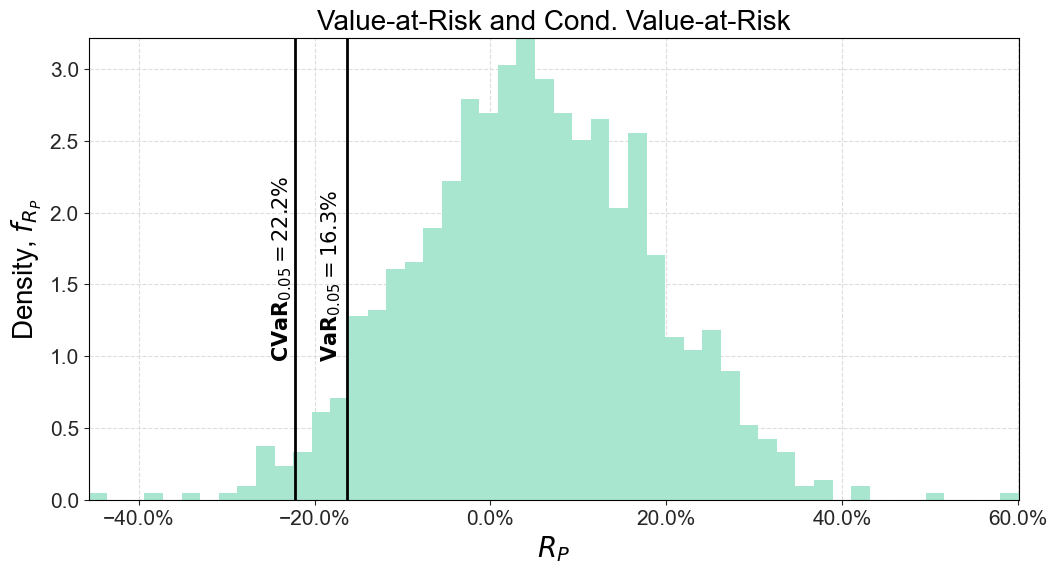

In [56]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_port_returns, density=True, bins=50);

ax.axvline(sim_var, ymin=0, ymax=8, color="black")
ax.axvline(sim_cvar, ymin=0, ymax=8, color="black")
ax.set_title("Value-at-Risk and Cond. Value-at-Risk", size=20)
ax.set_xlabel('$R_P$', size=20)
ax.set_ylabel('Density, $f_{R_P}$', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.1f}\%$".format(-sim_var*100)
ax.text(-0.195, 1.0, text_to_add, rotation=90);

text_to_add_2 =  "$\mathbf{CVaR}_{0.05}" + " = {:,.1f}\%$".format(-sim_cvar*100)
ax.text(-0.25, 1.0, text_to_add_2,rotation=90);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

__Question 2__

In [57]:
num_iter = 10000
num_sim = 1000

In [58]:
# simulate asset returns
sim_returns = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_iter))

# calculate portfolio returns for each simulation
sim_port_returns = sim_returns @ weights 

In [59]:
# Calculate VaR for all num_iter samples of num_sim observations
sim_var_all = calculate_value_at_risk(sim_port_returns, p=0.05, axis=0)

# Calculate CVaR for all num_iter samples of num_sim observations
sim_cvar_all = calculate_conditional_value_at_risk(sim_port_returns, p=0.05, axis=0)

In [60]:
# shape of numpy array with all VaR estimates
sim_var_all.shape

(10000,)

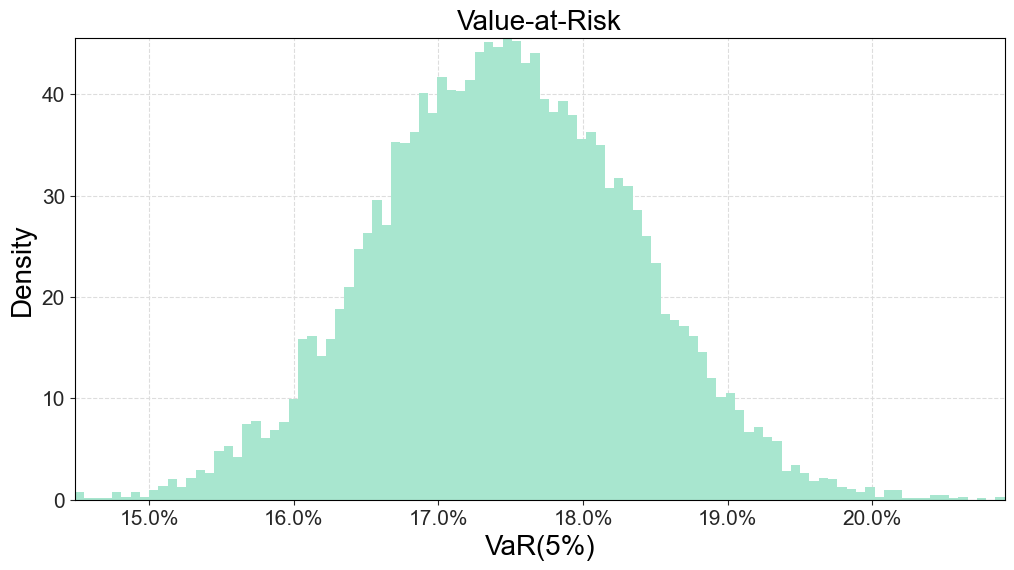

In [61]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(-sim_var_all, density=True, bins=100);

ax.set_title("Value-at-Risk", size=20)
ax.set_xlabel('VaR(5%)', size=20)
ax.set_ylabel('Density', size=20);


# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

In [62]:
# calculate the percentiles
np.percentile(-sim_var_all, [2.5, 97.5])

array([0.15709108, 0.19218943])

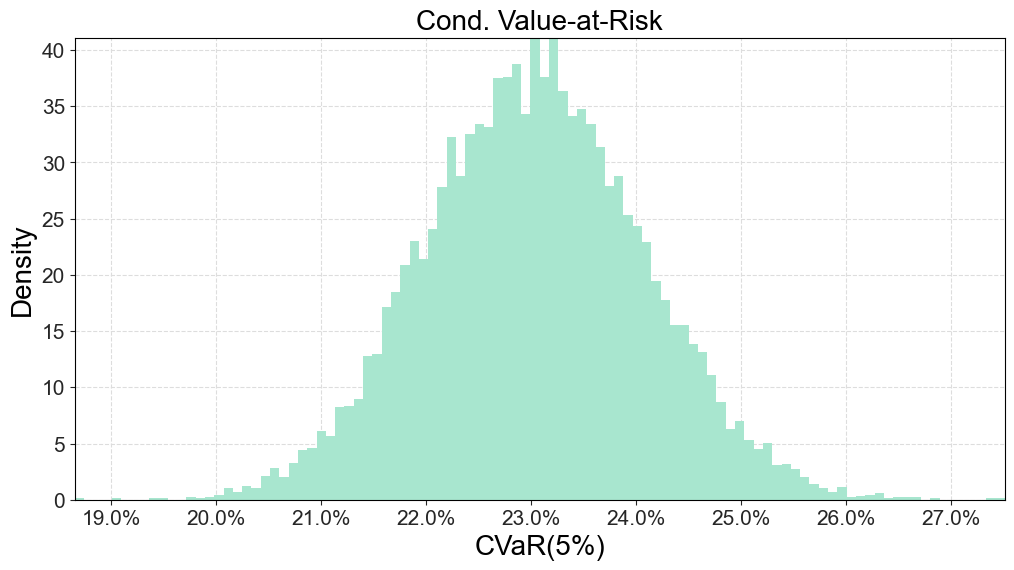

In [63]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(-sim_cvar_all, density=True, bins=100);

ax.set_title("Cond. Value-at-Risk", size=20)
ax.set_xlabel('CVaR(5%)', size=20)
ax.set_ylabel('Density', size=20);


# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

In [64]:
# calculate the percentiles
np.percentile(-sim_cvar_all, [2.5, 97.5])

array([0.20997912, 0.25102058])

__Question 3__

The functions `calculate_marginal_risks_cvar` and `calculate_risk_contributions_cvar` from `codelib.portfolio_optimization.risk_budget` implements the formulas.

In [65]:
# simulate asset returns
sim_returns = np.random.multivariate_normal(mu, cov_mat, size=num_sim)

# calculate portfolio returns for each simulation
sim_port_returns = sim_returns @ weights 

# cvar
cvar = calculate_conditional_value_at_risk(sim_port_returns, p=0.05)
-cvar

0.22244845946593098

In [66]:
# marginal risks
mr = calculate_marginal_risks_cvar(weights=weights, x=sim_returns, p=0.05)
-mr

array([0.04794578, 0.1798047 , 0.4395949 ])

In [67]:
# marginal risk contributions
mrc = calculate_risk_contributions_cvar(weights=weights, x=sim_returns, p=0.05)
-mrc

array([0.01598193, 0.0599349 , 0.14653163])

In [68]:
# equal to cvar!
-mrc.sum()

0.222448459465931

# References

## Articles

[Sarykalin, Serraino, Uryasev (2014)](https://pubsonline.informs.org/doi/abs/10.1287/educ.1080.0052)

## Books

[Riccardo Rebonato and Alexander Denev, "Portfolio Management under stress"](https://www.amazon.com/Portfolio-Management-under-Stress-Bayesian-Net/dp/1107048117)